# 02 - Training

## A - Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE

from metaboDGD.util import data, train
from metaboDGD.src import model
import matplotlib.pyplot as plt
import torch
import torch.distributions as D
import umap
import seaborn as sns

c:\AnacondaDestination\envs\metabodgd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## B - Retrieve Dataframe and Cohorts

In [2]:
dir = 'outputs/'
df_fname = 'CombinedDataset_CAMP_Normal.csv'
df_tumor_fname = 'CombinedDataset_CAMP_Tumor.csv'
cohorts_fname = 'cohorts.pkl'
cohorts_tumor_fname = 'cohorts_tumor.pkl'

In [3]:
df = pd.read_csv(dir + df_fname)
df.set_index('Unnamed: 0', inplace=True)
df.index.name = None
df_lbls = df.loc['cohort'].to_list()
df_log = df.T.drop(columns=['cohort']).astype('float64')

df_tumor = pd.read_csv(dir + df_tumor_fname)
df_tumor.set_index('Unnamed: 0', inplace=True)
df_tumor.index.name = None
df_tumor_lbls = df_tumor.loc['cohort'].to_list()
df_tumor_log = df_tumor.T.drop(columns=['cohort']).astype('float64')


# df_exp = pd.read_csv(dir + df_exp_fname)
# df_exp.set_index('Unnamed: 0', inplace=True)
# df_exp.index.name = None


f = open(dir + cohorts_fname, 'rb')
cohorts = pickle.load(f)
f.close()

ft = open(dir + cohorts_tumor_fname, 'rb')
cohorts_tumor = pickle.load(ft)

In [4]:
# ## Apply SMOTE so all classes are of size 47
# sm = SMOTE(random_state=100, k_neighbors=2)
# np_log_smote, df_lbls_smote = sm.fit_resample(df_log.to_numpy(), np.array(df_lbls))

# ## Update the sample_list for data loaders later
# complete_list = []
# for c in cohorts:
#     sample_list = cohorts[c]['sample_list']

#     if len(sample_list) < 47:
#         smote_sample_list = [c + '_' + str(x+1) for x in range(len(sample_list), 47)]
#         cohorts[c]['sample_list'] += smote_sample_list
#     complete_list += cohorts[c]['sample_list']
        
# df_log_smote = pd.DataFrame(np_log_smote, index=complete_list, columns=df_log.columns.to_list())

## C - Initializing DataLoaders and the DGD Model

In [5]:
train_dict = {}
test_dict  = {}

train_lbls = []
test_lbls  = []

In [7]:
train_loader, test_loader = data.create_dataloaders(
    cohorts=cohorts,
    df=df_log,
    batch_size=32
)

BRCA1: 37
ccRCC3: 37
ccRCC4: 19
COAD: 31
GBM: 4
HurthleCC: 2
PDAC: 9
PRAD: 36


In [8]:
dgd_model = model.MetaboDGD(
    latent_dim=5,
    output_dim=df_log.shape[1],
    dec_hidden_layers_dim=[500, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=8,
    cm_type='diagonal'
)

In [ ]:
# sb_prior_sample = dgd_model.gmm.means_prior['dist'].sample(10000)
# log_prob = dgd_model.gmm.means_prior['dist'].log_prob(sb_prior_sample).numpy()
# true_prob = np.exp(log_prob)
# plt.hist(log_prob, bins=50, density=True, edgecolor='black')
# plt.hist(sb_prior_sample[:,0], bins=50, density=True, edgecolor='black')
# plt.hist(sb_prior_sample[:,1], bins=50, density=True, edgecolor='black')
# plt.hist2d(sb_prior_sample[:,0], sb_prior_sample[:,1], bins=50)
# plt.show()

## D - Training the DGD Model

0
50
100
150
200


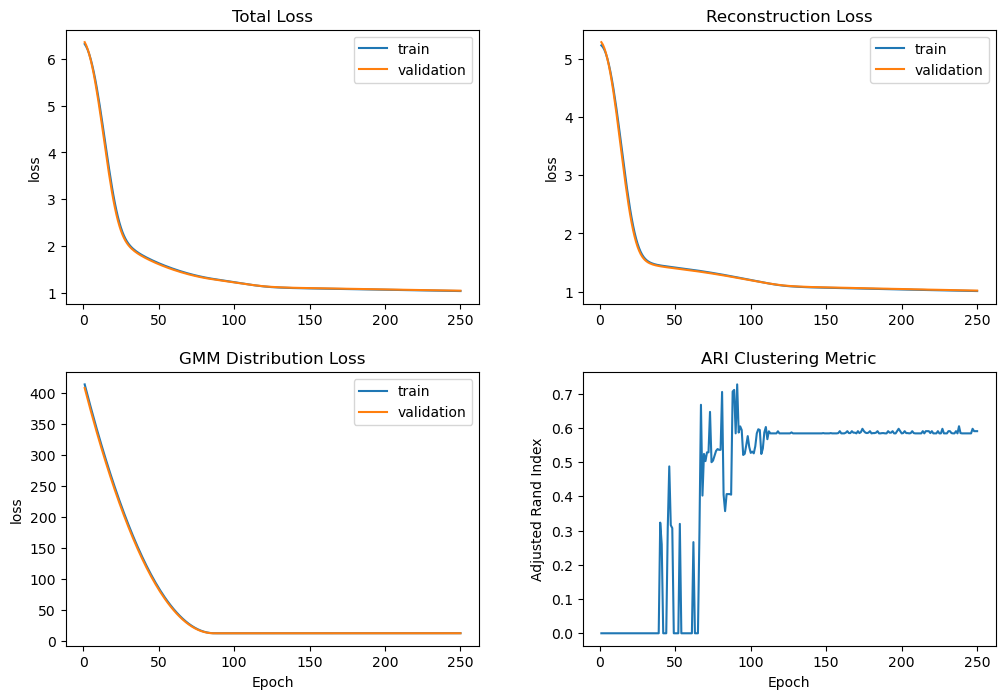

In [9]:
dgd_model, train_rep, test_rep, history, cm = train.train_dgd(
    dgd_model=dgd_model,
    train_loader=train_loader,
    validation_loader=test_loader,
    n_epochs=250,
    lr_schedule_epochs=None,
    lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
    optim_betas=[0.5, 0.7],
    wd=1e-5,
)

train.get_history_plot(history)

In [10]:
rep_final, dec_out_final = dgd_model.get_representations(df_tumor_log, df_tumor_lbls, df_tumor_log.shape[0])

## E - Hyperparameter Search

## F - Training Results

### The History Table

In [10]:
history

,train_loss,val_loss,train_recon_loss,val_recon_loss,train_dist_loss,val_dist_loss,cluster_acc,epoch
0,6.313024,6.352781,5.234076,5.288913,413.237118,407.461543,0.000000,1
1,6.259519,6.286316,5.204909,5.246648,403.915643,398.192969,0.000000,2
2,6.188549,6.200012,5.158049,5.184296,394.681549,389.019228,0.000000,3
3,6.098146,6.094654,5.091489,5.102603,385.549585,379.955437,0.000000,4
4,5.988941,5.970812,5.005838,5.002136,376.528301,371.003149,0.000000,5
...,...,...,...,...,...,...,...,...
245,1.045208,1.053993,1.012340,1.021203,12.588727,12.558782,0.583710,246
246,1.044869,1.052548,1.012002,1.019756,12.588206,12.559088,0.597124,247
247,1.044184,1.052499,1.011319,1.019703,12.587093,12.560781,0.590160,248
248,1.043697,1.051504,1.010827,1.018706,12.588897,12.561447,0.590160,249


### Figure X. Matrix

C:\Users\Alfonso Miguel Cruz\AppData\Local\Temp\ipykernel_41660\3824205586.py:1: RuntimeWarning: invalid value encountered in divide
  cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)


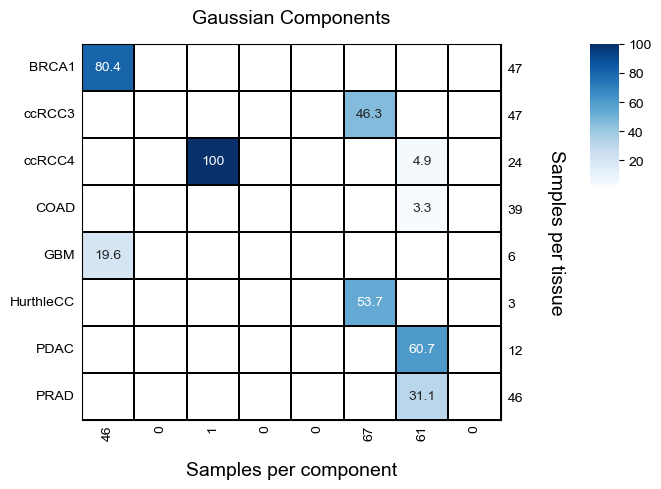

In [11]:
cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)
# np.sum(cm, axis=0)

class_lbls = list(cohorts.keys())
sample_num_lbls = [len(cohorts[c]['sample_list']) for c in cohorts.keys()]
plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.family"] = 'sans-serif'

zr_mask = np.where(cm_norm > 0, False, True)

fig, ax = plt.subplots(figsize=(7,5))

sns.heatmap(cm_norm, cmap='Blues',
            annot=True,
            fmt='g',
            xticklabels=np.sum(cm, axis=0),
            yticklabels=class_lbls,
            linewidths=0.1,
            mask=zr_mask,
            linecolor='black',
            ax=ax,
            cbar_kws={
                'pad': 0.15,
                'shrink': 0.375,
                'aspect': 5,
                'anchor': (0.0, 1.0)
            })

ax_y = ax.twinx()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(axis='both', length=0)

ax_y.set_yticks(ax.get_yticks())
ax_y.set_ylim(ax.get_ylim())
ax_y.set_yticklabels(sample_num_lbls)
ax_y.tick_params(axis='y', length=0)

ax.set_xlabel('Samples per component', fontsize=14, labelpad=15)
ax_y.set_ylabel('Samples per tissue' , fontsize=14, labelpad=30, rotation=270)

ax.tick_params(  axis='y', direction='out', pad=5)
ax_y.tick_params(axis='y', direction='out', pad=5)

ax.set_title('Gaussian Components', pad=15, fontsize=14)

# fig.subplots_adjust(bottom=0.5)
plt.tight_layout()

### Figure X. PCA Code

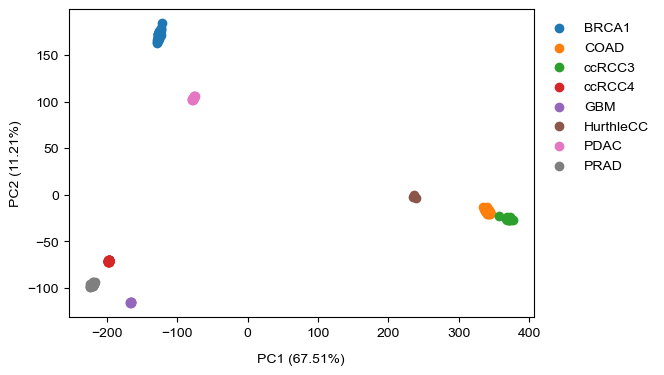

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(df_log.to_numpy())

fig, ax = plt.subplots(figsize=(6,4))
### ALL 
ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    )
ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     )
ax.scatter(pca_fit[94:118,0]  , pca_fit[94:118,1]  , label='ccRCC3' )
ax.scatter(pca_fit[118:157,0] , pca_fit[118:157,1] , label='ccRCC4' )
ax.scatter(pca_fit[157:163,0], pca_fit[157:163,1], label='GBM'      )
ax.scatter(pca_fit[163:166,0], pca_fit[163:166,1], label='HurthleCC')
ax.scatter(pca_fit[166:178,0], pca_fit[166:178,1], label='PDAC'     )
ax.scatter(pca_fit[178:224,0], pca_fit[178:224,1], label='PRAD'     )


ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')
# ax.set_xlabel('UMAP D1')
# ax.set_ylabel('UMAP D2')
ax.legend(bbox_to_anchor=(1.275, 1),loc='upper right', fancybox=False, framealpha=0.0)

In [15]:
pca.explained_variance_ratio_

array([0.67508208, 0.11211   ])

# OTHER CODE

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_log.to_numpy())
for (i,j) in [(0,47), (47,94), (94,118), (118,157), (157,163), (163,166), (166,178), (178,224)]:
    print(np.var(pca_fit[i:j], axis=0))

In [ ]:
x = np.array([
[2.32078454,15.44278658,  0.16024287, 0.50076828, 1.44459359],
[5.76099106,  2.9719728,  1.77597046, 0.45738981, 1.58652234],
[11.66611275,1.32510036, 10.29634677, 0.31121013, 1.57775395],
[0.27430105, 0.31315221,  0.38402532, 0.03392115, 0.17598611],
[0.16735727, 0.30873464,  0.02512788, 3.94248676, 0.10560584],
[2.38964571, 1.12885473,  0.11152993, 0.04679803, 0.59536716],
[1.11657805, 2.01189821,  0.58198513, 0.28459389, 5.12391001],
[2.41024798, 1.63209868,  0.36540129, 0.19185093, 1.94765308],
], dtype=np.float64)
x = x.flatten()

plt.hist(x)
plt.axvline(x=np.mean(x), c='red')

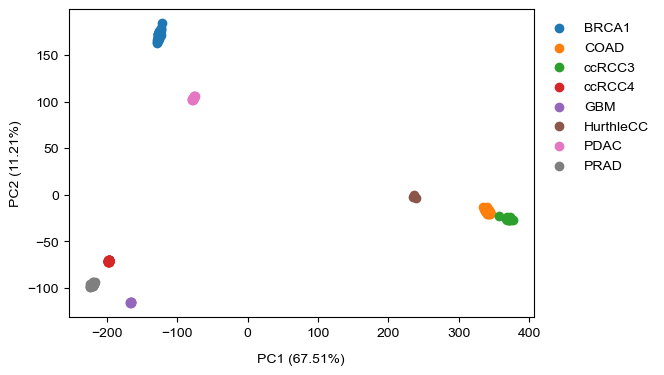

In [ ]:
# import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(df_log.to_numpy())
# pca_fit = pca.fit_transform(np.exp2(df.T.to_numpy()[:,:-1].astype(np.float64)))
# pca_fit = pca.fit_transform(train_rep.z.detach().numpy())
# pca_fit = pca.fit_transform(test_rep.z.detach().numpy())

# um = umap.UMAP(random_state=100)
# pca_fit = um.fit_transform(df.T.to_numpy()[:, :-1])
# pca_fit = um.fit_transform(df_exp_smote.to_numpy())
# pca_fit = um.fit_transform(train_rep.z.detach().numpy())
fig, ax = plt.subplots(figsize=(6,4))
### ALL 
# ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    )
# ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     )
# ax.scatter(pca_fit[94:118,0]  , pca_fit[94:118,1]  , label='ccRCC3' )
# ax.scatter(pca_fit[118:157,0] , pca_fit[118:157,1] , label='ccRCC4' )
# ax.scatter(pca_fit[157:163,0], pca_fit[157:163,1], label='GBM'      )
# ax.scatter(pca_fit[163:166,0], pca_fit[163:166,1], label='HurthleCC')
# ax.scatter(pca_fit[166:178,0], pca_fit[166:178,1], label='PDAC'     )
# ax.scatter(pca_fit[178:224,0], pca_fit[178:224,1], label='PRAD'     )
# ax.set_title('PCA - ALL')

### TRAIN_REP
# ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]   , label='BRCA1'    )
# ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]  , label='COAD'     )
# ax.scatter(pca_fit[74:93,0]  , pca_fit[74:93,1]  , label='ccRCC3'   )
# ax.scatter(pca_fit[93:124,0] , pca_fit[93:124,1] , label='ccRCC4'   )
# ax.scatter(pca_fit[124:128,0], pca_fit[124:128,1], label='GBM'      )
# ax.scatter(pca_fit[128:130,0], pca_fit[128:130,1], label='HurthleCC')
# ax.scatter(pca_fit[130:139,0], pca_fit[130:139,1], label='PDAC'     )
# ax.scatter(pca_fit[139:175,0], pca_fit[139:175,1], label='PRAD'     )
# ax.set_title('PCA - TRAIN_REP')

### TEST_REP
# ax.scatter(pca_fit[0:10,0]   , pca_fit[0:10,1]   , label='BRCA1' )
# ax.scatter(pca_fit[10:20,0]  , pca_fit[10:20,1]  , label='COAD'  )
# ax.scatter(pca_fit[20:25,0]  , pca_fit[20:25,1]  , label='ccRCC3')
# ax.scatter(pca_fit[25:33,0] , pca_fit[25:33,1] , label='ccRCC4'  )
# ax.scatter(pca_fit[33:35,0], pca_fit[33:35,1], label='GBM'       )
# ax.scatter(pca_fit[35:36,0], pca_fit[35:36,1], label='HurthleCC' )
# ax.scatter(pca_fit[36:39,0], pca_fit[36:39,1], label='PDAC'      )
# ax.scatter(pca_fit[39:49,0], pca_fit[39:49,1], label='PRAD'      )
# ax.set_title('PCA - TEST_REP')


### SMOTE - TEST_REP
# ax.scatter(pca_fit[0:10,0]   , pca_fit[0:10,1]   , label='BRCA1' )
# ax.scatter(pca_fit[10:20,0]  , pca_fit[10:20,1]  , label='COAD'  )
# ax.scatter(pca_fit[20:30,0]  , pca_fit[20:30,1]  , label='ccRCC3')
# ax.scatter(pca_fit[30:40,0] , pca_fit[30:40,1] , label='ccRCC4'  )
# ax.scatter(pca_fit[40:50,0], pca_fit[40:50,1], label='GBM'       )
# ax.scatter(pca_fit[50:222,0], pca_fit[50:60,1], label='HurthleCC')
# ax.scatter(pca_fit[60:70,0], pca_fit[60:70,1], label='PDAC'      )
# ax.scatter(pca_fit[70:80,0], pca_fit[70:80,1], label='PRAD'      )

### SMOTE - TRAIN_REP
# ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]     , label='BRCA1'    )
# ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]    , label='COAD'     )
# ax.scatter(pca_fit[74:111,0]  , pca_fit[74:111,1]  , label='ccRCC3'   )
# ax.scatter(pca_fit[111:148,0] , pca_fit[111:148,1] , label='ccRCC4'   )
# ax.scatter(pca_fit[148:185,0], pca_fit[148:185,1]  , label='GBM'      )
# ax.scatter(pca_fit[185:222,0], pca_fit[185:222,1]  , label='HurthleCC')
# ax.scatter(pca_fit[222:259,0], pca_fit[222:259,1]  , label='PDAC'     )
# ax.scatter(pca_fit[259:296,0], pca_fit[259:296,1]  , label='PRAD'     )

### SMOTE - ALL
# ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    )
# ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     )
# ax.scatter(pca_fit[94:141,0]  , pca_fit[94:141,1]  , label='ccRCC3' )
# ax.scatter(pca_fit[141:188,0] , pca_fit[141:188,1] , label='ccRCC4' )
# ax.scatter(pca_fit[188:235,0], pca_fit[188:235,1], label='GBM'      )
# ax.scatter(pca_fit[235:282,0], pca_fit[235:282,1], label='HurthleCC')
# ax.scatter(pca_fit[282:329,0], pca_fit[282:329,1], label='PDAC'     )
# ax.scatter(pca_fit[329:376,0], pca_fit[329:376,1], label='PRAD'     )


# ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
# ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')
# ax.set_xlabel('UMAP D1')
# ax.set_ylabel('UMAP D2')
# ax.legend(bbox_to_anchor=(1.275, 1),loc='upper right', fancybox=False, framealpha=0.0)

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.decomposition import PCA


# lbls_all = df.T['cohort'].to_list()
# # le = LabelEncoder()
# # lbls_all_id = le.fit_transform(lbls_all)

# fig, ax = plt.subplots(figsize=(7,5))
# pca = PCA(n_components=2)
# pca_fit = pca.fit_transform(df_log.to_numpy())
# ax.scatter(pca_fit[:, 0], pca_fit[:, 1], c=lbls_all_id, cmap='tab10')
# # ax.set_title('PCA - ALL')
# ax.set_xlabel(f'PC1: {(pca.explained_variance_ratio_[0] * 100):.2f}%')
# ax.set_ylabel(f'PC2: {(pca.explained_variance_ratio_[1] * 100):.2f}%')

# ax.legend(bbox_to_anchor=(1.30, 1),loc='upper right', fancybox=False, framealpha=0.0)

# WANDB Code

In [ ]:
# 873f16d32cf5f8595722bf04c6ead0f9415ad6af
import random

import wandb

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="alfonso_cruz-de-la-salle-university",
    # Set the wandb project where this run will be logged.
    project="my-first-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'cluster_acc',
        'goal': 'maximize'
    },
    'paramters': {
        'latent_dim': {
            'values': [5, 10, 20, 30],
        },
        'dirichlet_alpha': {
            'values': [0.5, 1, 3, 5],
        },
        'softball_radius': {
            'values': [1, 5, 10],
        },
        'softball_sharpness': {
            'values': [1, 5, 10],
        }
    }
}

"""
sweep_id = wandb.sweep(sweep_config, project='TODO')
wandb.agent(sweep_id, train, count=5)
"""

## WITH SMOTE

In [ ]:
test_cohorts = cohorts.copy()

In [ ]:
from sklearn.decomposition import PCA

X = df_exp.to_numpy()
y = np.array(df_lbls)

sm = SMOTE(random_state=100, k_neighbors=2)
X_new, y_new = sm.fit_resample(X, y)


pca = PCA(n_components=2)
res = pca.fit_transform(X_new)

sum = 0
colors = {
    'BRCA1': 'red',
    'ccRCC3': 'orange',
    'ccRCC4': 'yellow',
    'COAD': 'green',
    'GBM': 'blue',
    'HurthleCC': 'purple',
    'PDAC': 'brown',
    'PRAD': 'black',
}

for i in np.unique(y_new).tolist():
    plt.scatter(res[sum:sum+47, 0], res[sum:sum+47, 1], c=colors[i])
    sum += 47

plt.xlabel(pca.explained_variance_ratio_[0] * 100)
plt.ylabel(pca.explained_variance_ratio_[1] * 100)
plt.title("PCA after SMOTE")